# Leaf Outline

In [8]:
def leaf_outline(image_path):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Create masks for the calibration cube, leaf, and scars
    green_lower = np.array([35, 40, 40])
    green_upper = np.array([85, 255, 255])

    # Create masks for the calibration leaf
    green_mask = cv2.inRange(hsv_image, green_lower, green_upper)

    # Find contours of the leaf
    leaf_contours, _ = cv2.findContours(green_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    leaf_contour = max(leaf_contours, key=cv2.contourArea)

    # Optionally display the results visually
    cv2.drawContours(image, [leaf_contour], -1, (0, 255, 0), 2)

    return image, leaf_contour

(-0.5, 1311.5, 1919.5, -0.5)

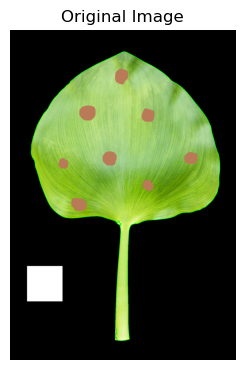

In [9]:
image, leaf_contour = leaf_outline("Leaf-with-scars-1.png")


import cv2
import matplotlib.pyplot as plt

# Display the segmented image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

(-0.5, 432.5, 576.5, -0.5)

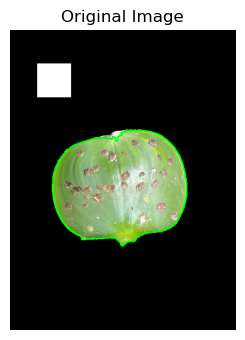

In [10]:
image, leaf_contour = leaf_outline("Leaf_1_Cube.png")


import cv2
import matplotlib.pyplot as plt

# Display the segmented image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

# Scar Counting

In [11]:
def scar_counting(image_path):
    import cv2
    import numpy as np

    # Load the water hyacinth scar image
    # image_path = r"Leaf_1.png"
    image = cv2.imread(image_path)
    # cv2.imshow("Original", image)

    # Copy the image for masking
    result = image.copy()

    # Convert image to HSV color space
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define HSV color range for brownish scars on water hyacinth
    lower_brown = np.array([10, 50, 20])   # Lower bound for brown hues
    upper_brown = np.array([20, 255, 200]) # Upper bound for brown hues

    # Create mask based on the defined brown color range
    brown_mask = cv2.inRange(image_hsv, lower_brown, upper_brown)

    # Apply mask to get only the brown regions
    result = cv2.bitwise_and(result, result, mask=brown_mask)

    # Find contours in the brown mask
    contours, _ = cv2.findContours(brown_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to keep track of merged contours
    merged_contours = []

    # Distance threshold in pixels (for 0.1 cm)
    distance_threshold = 10  # 0.1 cm in pixels (100 pixels/cm * 0.1 cm)

    # Process contours to merge close scars
    for contour in contours:
        if len(contour) > 0:
            # Calculate the centroid of the current contour
            M = cv2.moments(contour)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                continue

            # Check if this centroid is too close to any existing merged contour centroid
            too_close = False
            for merged_contour in merged_contours:
                # Calculate the distance between the centroids
                merged_M = cv2.moments(merged_contour)
                merged_cX = int(merged_M["m10"] / merged_M["m00"])
                merged_cY = int(merged_M["m01"] / merged_M["m00"])

                distance = np.sqrt((cX - merged_cX) ** 2 + (cY - merged_cY) ** 2)
                if distance < distance_threshold:
                    too_close = True
                    break

            # If it's not too close to any merged contour, add it
            if not too_close:
                merged_contours.append(contour)

    # Count the number of merged scars
    scar_count = len(merged_contours)

    # Show results
    # print(f"Total scars identified (merged): {scar_count}")
    # cv2.imshow('Brown Mask', brown_mask)
    # cv2.imshow('Result with Brown Scars Highlighted', result)

    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return scar_count

In [4]:
scar_count = scar_counting("Leaf-with-scars-1.png")
print(f"Total scars identified (merged): {scar_count}")

Total scars identified (merged): 8


In [12]:
scar_count = scar_counting("Leaf_1_Cube.png")
print(f"Total scars identified (merged): {scar_count}")

Total scars identified (merged): 28


# Filtering Test

In [13]:
def filter_image(image_paths):
    import cv2
    import numpy as np

    # List of image paths
    # image_paths = ['Sample Data/RealImage1.jpg']
    # image_paths = ['Leaf-with-scars-1.png']

    # Loop through each image
    for image_path in image_paths:
        # Load the image
        frame = cv2.imread(image_path)
        if frame is not None:
            # Convert the BGR color space of the image to HSV color space
            hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

            # Detect the white cube for pixel-to-cm ratio
            lower_white = np.array([0, 0, 200])  # Lower bound for white (low saturation, high value)
            upper_white = np.array([180, 55, 255])  # Upper bound for white
            cube_mask = cv2.inRange(hsv, lower_white, upper_white)
            contours, _ = cv2.findContours(cube_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

            if len(contours) > 0:
                # Assuming the largest white contour is the cube
                cube_contour = max(contours, key=cv2.contourArea)

                # Get bounding rectangle of the contour
                x, y, w, h = cv2.boundingRect(cube_contour)

                if w > 0 and h > 0:
                    cube_size_in_pixels = max(w, h)  # Taking the larger side
                    pixel_to_cm_ratio = cube_size_in_pixels / 2.0  # 2 cm cube
                    print(f'Image: {image_path}')
                    print(f'Pixel-to-cm Ratio: {pixel_to_cm_ratio:.2f} pixels/cm')

                    # Calculate cube area in pixels and cm²
                    cube_area_pixels = w * h
                    cube_area_cm2 = cube_area_pixels / (pixel_to_cm_ratio ** 2)
                    actual_cube_area_cm2 = 2.0 * 2.0  # 2 cm by 2 cm

                    # Calculate the percentage error
                    cube_area_percentage = (cube_area_cm2 / actual_cube_area_cm2) * 100
                    print(f'Calculated Cube Area: {cube_area_cm2:.2f} cm²')
                    print(f'Actual Cube Area: {actual_cube_area_cm2} cm²')
                    print(f'Cube Area Percentage (compared to actual area): {cube_area_percentage:.2f}%')

                    # Healthy leaf (green)
                    lower_Healthy = np.array([40, 100, 60])
                    upper_Healthy = np.array([80, 255, 180])
                    # Unhealthy leaf (yellow-ish or dying)
                    lower_Unhealthy = np.array([15, 100, 100])
                    upper_Unhealthy = np.array([35, 255, 255])
                    # Scar (brown)
                    lower_Scar = np.array([0, 50, 50])
                    upper_Scar = np.array([20, 150, 200])

                    # Masks for green (leaf), yellow (dying parts), and brown (scars)
                    green_mask = cv2.inRange(hsv, lower_Healthy, upper_Healthy)
                    yellow_mask = cv2.inRange(hsv, lower_Unhealthy, upper_Unhealthy)
                    brown_mask = cv2.inRange(hsv, lower_Scar, upper_Scar)

                    # Combine green, yellow, and brown masks to detect the entire leaf
                    leaf_mask = cv2.bitwise_or(green_mask, brown_mask)
                    leaf_mask = cv2.bitwise_or(leaf_mask, yellow_mask)

                    # Apply the mask to the original image to extract the leaf, dying parts, and scars
                    leaf = cv2.bitwise_and(frame, frame, mask=leaf_mask)

                    # Calculate areas (in pixels)
                    total_leaf_pixels = cv2.countNonZero(leaf_mask)
                    scar_pixels = cv2.countNonZero(brown_mask)
                    dying_pixels = cv2.countNonZero(yellow_mask)
                    healthy_pixels = cv2.countNonZero(green_mask)

                    # Convert to cm² using the pixel-to-cm ratio
                    leaf_area_cm2 = total_leaf_pixels / (pixel_to_cm_ratio ** 2)
                    scar_area_cm2 = scar_pixels / (pixel_to_cm_ratio ** 2)
                    dying_area_cm2 = dying_pixels / (pixel_to_cm_ratio ** 2)
                    healthy_area_cm2 = healthy_pixels / (pixel_to_cm_ratio ** 2)

                    # Calculate damage percentage and unhealthy percentage
                    damage_percentage = (scar_area_cm2 / leaf_area_cm2) * 100
                    unhealthy_percentage = (dying_area_cm2 / leaf_area_cm2) * 100
                    healthy_percentage = (healthy_area_cm2 / leaf_area_cm2) * 100

                    # Print the results
                    print(f'Total Leaf Area (Healthy + Dying + Scars): {leaf_area_cm2:.2f} cm²')
                    print(f'Scar Area: {scar_area_cm2:.2f} cm²')
                    print(f'Dying Area: {dying_area_cm2:.2f} cm²')
                    print(f'Healthy Area: {healthy_area_cm2:.2f} cm²')
                    print(f'Damage Percentage: {damage_percentage:.2f}%')
                    print(f'Unhealthy (Yellow) Percentage: {unhealthy_percentage:.2f}%')
                    print(f'Healthy (Green) Percentage: {healthy_percentage:.2f}%')

                    # Calculate Leaf length and width
                    x_leaf, y_leaf, w_leaf, h_leaf = cv2.boundingRect(leaf_mask)
                    leaf_length_cm = h_leaf / pixel_to_cm_ratio
                    leaf_width_cm = w_leaf / pixel_to_cm_ratio
                    print(f'Leaf Length: {leaf_length_cm:.2f} cm')
                    print(f'Leaf Width: {leaf_width_cm:.2f} cm')

                    # Resize image for display
                    scale_percent = 50  # percent of original size
                    width = int(frame.shape[1] * scale_percent / 100)
                    height = int(frame.shape[0] * scale_percent / 100)
                    dim = (width, height)

                    resized_frame = cv2.resize(frame, dim, interpolation=cv2.INTER_AREA)
                    resized_leaf = cv2.resize(leaf, dim, interpolation=cv2.INTER_AREA)
                    resized_cube_mask = cv2.resize(cube_mask, dim, interpolation=cv2.INTER_AREA)

                    # Function to add label to the image
                    def add_label(image, text):
                        font = cv2.FONT_HERSHEY_SIMPLEX
                        font_scale = 0.5
                        color = (255, 255, 255)
                        thickness = 1
                        position = (10, 30)
                        cv2.putText(image, text, position, font, font_scale, color, thickness, cv2.LINE_AA)
                        return image

                    # Add labels to each image
                    labeled_resized_frame = add_label(resized_frame, 'Original Image')
                    labeled_resized_leaf = add_label(resized_leaf, 'Extracted Leaf')
                    labeled_resized_cube_mask = add_label(cv2.cvtColor(resized_cube_mask, cv2.COLOR_GRAY2BGR), 'Calibration Cube')

                    # Arrange the images in a grid (2 rows, 2 columns)
                    row1 = cv2.hconcat([labeled_resized_frame, labeled_resized_leaf])
                    row2 = cv2.hconcat([labeled_resized_cube_mask, labeled_resized_cube_mask])

                    # Combine the rows vertically
                    final_display = cv2.vconcat([row1, row2])

                    # Display the combined image for each image in the list
                    # cv2.imshow(f'Leaf Analysis ({image_path})', final_display)

                    # Wait for a key press to move to the next image
                    # cv2.waitKey(0)

                    # Close the window before moving to the next image
                    # cv2.destroyAllWindows()

            else:
                print(f"Cube not found for pixel-to-cm ratio in {image_path}!")

        else:
            print(f"Image not found or path is incorrect: {image_path}")

In [15]:
filter_image(["Leaf-with-scars-1.png"])

Image: Leaf-with-scars-1.png
Pixel-to-cm Ratio: 103.00 pixels/cm
Calculated Cube Area: 4.00 cm²
Actual Cube Area: 4.0 cm²
Cube Area Percentage (compared to actual area): 100.00%
Total Leaf Area (Healthy + Dying + Scars): 13.48 cm²
Scar Area: 3.55 cm²
Dying Area: 0.34 cm²
Healthy Area: 9.61 cm²
Damage Percentage: 26.38%
Unhealthy (Yellow) Percentage: 2.49%
Healthy (Green) Percentage: 71.34%
Leaf Length: 16.30 cm
Leaf Width: 10.39 cm
